# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Fixes the FloatProgess import error
!pip install ipywidgets
!juypter nbextension enable --py widgetsnbextension
from ipywidgets import FloatProgress

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 138 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 32.2 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 40.9 MB/s eta 0:00:01
/bin/sh: 1: juypter: not found


ModuleNotFoundError: No module named 'ipywidgets'

In [5]:
INPUT_SIZE=28
OUTPUT_SIZE=10
BATCH_SIZE=20

In [9]:
# Define transforms
train_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])

# Create training & testing set
dataset = torchvision.datasets.MNIST(root='./MNIST', train=True, download=True, transform=train_transforms)
proportions = [0.8, 0.2]
lengths = [int(p * len(dataset)) for p in proportions]
lengths[-1] = len(dataset) - sum(lengths[:-1])
train, valid = torch.utils.data.random_split(dataset, lengths)

test = torchvision.datasets.MNIST(root='./MNIST', train=False, download=True, transform=test_transforms)




# Define train & test set dataloader
trainloader = torch.utils.data.DataLoader(train,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,)
validloader = torch.utils.data.DataLoader(valid,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,)
testloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)

In [10]:
# Checking the dataloader working as expected

print(f"Training dataset size: {len(train)}")
print(f"Validation dataset size: {len(valid)}")
print(f"Testing dataset size: {len(test)}\n")

for images, labels in trainloader:
    print(f'Images in each batch: {len(images)}')
    print(f'Image Shape: {images[0].shape}')
    break

for images, labels in testloader:
    print(f'Images in each batch: {len(images)}')
    print(f'Image Shape: {images[0].shape}')
    break

Training dataset size: 48000
Validation dataset size: 12000
Testing dataset size: 10000

Images in each batch: 20
Image Shape: torch.Size([1, 28, 28])
Images in each batch: 20
Image Shape: torch.Size([1, 28, 28])


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

- I normalize the dataset images because it brings the pixel value of image to similar scale, generalises the model to unseen images, also the remove the bias present in the dataset and gives more stable model for real-world data.
- I also tried data augmentation like vertical flip, horizontal flip, etc but these transformation degrades the model accuracy may be because it makes the model more complex and test data are similar to training data.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [17]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


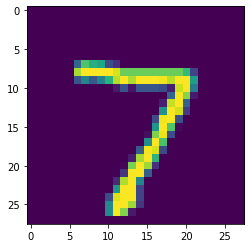

2


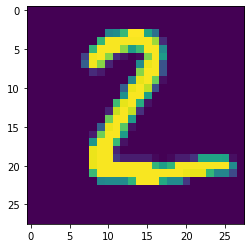

1


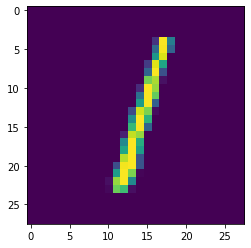

0


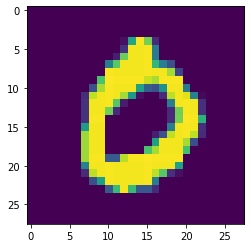

4


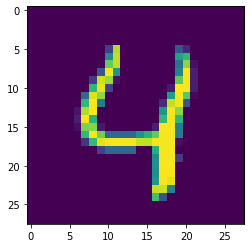

In [18]:
# Explore data
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [38]:
class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.in_size=in_size
        self.fc1=nn.Linear(in_size, 256)
        self.fc2=nn.Linear(256, 128)
        self.out=nn.Linear(128, out_size)

        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        x = x.flatten(1)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)
        return x


In [39]:
net = Net(INPUT_SIZE*INPUT_SIZE, OUTPUT_SIZE)
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [40]:
# Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [41]:
n_epochs = 15

train_losses = []
val_losses = []

In [42]:
for epoch in range(n_epochs):
    net.train()

    # Training Loop
    train_loss = 0
    train_correct = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1}: training accuracy: {100*train_correct/len(trainloader.dataset):.2f}% training loss: {train_loss/len(trainloader):.5f}')
    train_losses.append(train_loss/len(trainloader))

    # Validation Loop
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
    print(f'Epoch {epoch + 1}: validation accuracy: {100*val_correct/len(validloader.dataset):.2f}% validation loss: {val_loss/len(validloader):.5f}\n')
    val_losses.append(val_loss/len(validloader))


Epoch 1: training accuracy: 87.06% training loss: 0.40903
Epoch 1: validation accuracy: 92.49% validation loss: 0.24281

Epoch 2: training accuracy: 92.95% training loss: 0.23270
Epoch 2: validation accuracy: 94.13% validation loss: 0.20380

Epoch 3: training accuracy: 94.18% training loss: 0.19235
Epoch 3: validation accuracy: 94.28% validation loss: 0.19070

Epoch 4: training accuracy: 94.80% training loss: 0.17294
Epoch 4: validation accuracy: 95.06% validation loss: 0.17470

Epoch 5: training accuracy: 95.22% training loss: 0.15866
Epoch 5: validation accuracy: 94.20% validation loss: 0.20105

Epoch 6: training accuracy: 95.36% training loss: 0.15064
Epoch 6: validation accuracy: 94.62% validation loss: 0.18698

Epoch 7: training accuracy: 95.56% training loss: 0.14269
Epoch 7: validation accuracy: 95.53% validation loss: 0.15896

Epoch 8: training accuracy: 95.84% training loss: 0.13825
Epoch 8: validation accuracy: 94.83% validation loss: 0.18758

Epoch 9: training accuracy: 95.8

Plot the training loss (and validation loss/accuracy, if recorded).

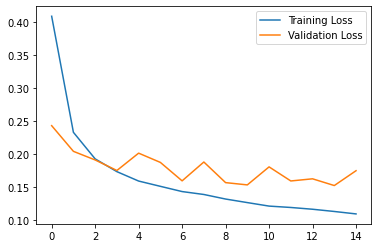

In [43]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [46]:
test_loss = 0
test_correct = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()
print(f'Test accuracy: {100*test_correct/len(testloader.dataset):.2f}% Test loss: {test_loss/len(testloader):.5f}')

Test accuracy: 95.42% Test loss: 0.17339


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [67]:
# WRITE YOUR CODE HERE

## Saving your model
Using `torch.save`, save your model for future loading.

In [47]:
torch.save(net, './checkpoint.pth')